In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.optimize import minimize
from datetime import datetime

In [3]:
# ==========================
# Step 1: Data Collection (Live Data Integration)
# ==========================

def fetch_sp500_tickers():
    """Fetch S&P 500 tickers from Wikipedia."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_table = pd.read_html(url)[0]
    return sp500_table[['Symbol', 'GICS Sector']]

def clean_tickers(tickers):
    """Fix tickers with dot notation for Yahoo Finance."""
    return [t.replace('.', '-') for t in tickers]  # BRK.B → BRK-B

def filter_valid_tickers(tickers, start_date, end_date):
    """Check which tickers have valid data on Yahoo Finance."""
    valid_tickers = []
    for ticker in tickers:
        try:
            data = yf.Ticker(ticker).history(start=start_date, end=end_date)
            if not data.empty:
                valid_tickers.append(ticker)
            else:
                print(f"Skipping {ticker}: No data found.")
        except Exception as e:
            print(f"Skipping {ticker}: {e}")
    return valid_tickers

def fetch_stock_data(tickers, start_date, end_date):
    """Download stock data for valid tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # Check if 'Adj Close' exists in the returned data
    if 'Adj Close' in data:
        return data['Adj Close'].dropna(axis=1)  # Remove columns with NaN
    else:
        print("Warning: 'Adj Close' column not found in data. Returning raw data.")
        return data  # Return the whole DataFrame for debugging

# Fetch tickers and clean them
sp500_companies = fetch_sp500_tickers()
tickers = clean_tickers(sp500_companies['Symbol'].tolist())

# Define date range
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Validate tickers and fetch data
valid_tickers = filter_valid_tickers(tickers, start_date, end_date)
data = fetch_stock_data(valid_tickers, start_date, end_date)

# Display the first few rows
print(data.head())


Could not get exchangeTimezoneName for ticker 'ETR' reason: 'chart'
$ETR: possibly delisted; no timezone found


Skipping ETR: No data found.


$HWM: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping HWM: No data found.


$J: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping J: No data found.


$LEN: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping LEN: No data found.


[*********************100%***********************]  499 of 499 completed


Price           Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2018-01-02  64.180237  40.524345  71.669937  NaN  51.776573  27.988113   
2018-01-03  65.813232  40.517292  72.791473  NaN  51.891060  28.013470   
2018-01-04  65.319542  40.705490  72.376358  NaN  51.802990  28.118069   
2018-01-05  66.363869  41.168930  73.636261  NaN  51.952713  28.007132   
2018-01-08  66.506287  41.016026  72.456467  NaN  51.802990  28.010302   

Price                                                     ...  Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...     WTW   
Date                                                      ...           
2018-01-02  138.659637  177.699997  79.129028  32.879108  ...  817700   
2018-01-03  139.299591  181.039993  80.110703  32.624878  ...  771200   
2018-01-04  140.949005  183.220001  80.023

In [4]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# ==========================
# Step 2: Feature Engineering (Risk, Liquidity & Macro)
# ==========================
# Compute returns and volatility
returns = data.pct_change().dropna()
volatility = returns.rolling(window=20).std().dropna()

def compute_beta(stock_returns, market_returns):
    """Calculate Beta for each stock."""
    if stock_returns.isna().sum() > 0 or market_returns.isna().sum() > 0:
        return np.nan  # Handle missing values
    
    covariance = np.cov(stock_returns.dropna(), market_returns.dropna())[0, 1]
    market_variance = np.var(market_returns.dropna())

    return covariance / market_variance if market_variance > 0 else np.nan

# Approximate S&P 500 market return
sp500_returns = returns.mean(axis=1)

# Compute feature matrix
features = pd.DataFrame({
    "mean_return": returns.mean() * 252,
    "volatility": volatility.mean(),
    "cumulative_return": (data.iloc[-1] / data.iloc[0]) - 1,
    "sharpe_ratio": returns.mean() / (returns.std() + 1e-8),  # Avoid div-by-zero
    "sortino_ratio": returns.mean() / (returns[returns < 0].std() + 1e-8),  # Avoid div-by-zero
    "max_drawdown": (data / data.cummax() - 1).min(),
    "var_95": returns.quantile(0.05),
    "beta": [compute_beta(returns[ticker], sp500_returns) for ticker in returns.columns],
    "liquidity": data.mean(),  # Approximate by average price
})

# Handle Inf and NaNs before scaling
features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
features.dropna(inplace=True)  # Drop rows with NaN values

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame
features_scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

# Display first few rows
print(features_scaled_df.head())


C:\Users\bhavy\AppData\Local\Temp\ipykernel_1812\3950672875.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


              mean_return  volatility  cumulative_return  sharpe_ratio  \
Price Ticker                                                             
Close A         -0.461323   -0.489201          -0.067622     -0.047252   
      AAPL      -0.488133   -0.499602           1.201692     -0.772085   
      ABBV      -0.457299   -0.487787           0.082550     -0.036496   
      ABT       -0.443102   -0.508513           0.019517      0.721704   
      ACGL      -0.487660   -0.486642           0.340338     -0.767860   

              sortino_ratio  max_drawdown    var_95      beta  liquidity  
Price Ticker                                                              
Close A           -0.229725      0.805470  0.505174 -0.469136  -0.115417  
      AAPL        -0.741822      0.993460  0.484087 -0.464818  -0.115415  
      ABBV        -0.421048      0.700538  0.526798 -0.467043  -0.115417  
      ABT          0.235034      1.200175  0.542720 -0.476886  -0.115418  
      ACGL        -0.737386    

In [5]:
# ==========================
# Step 3: Advanced Clustering (Hierarchical + GMM + DBSCAN)
# ==========================
# Use scaled features for clustering
X_scaled = features_scaled_df.copy()

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=10, linkage='ward')
X_scaled['hierarchical_cluster'] = hierarchical.fit_predict(features_scaled_df)

# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
X_scaled['gmm_cluster'] = gmm.fit_predict(features_scaled_df)

# DBSCAN Clustering (Density-based)
dbscan = DBSCAN(eps=1.5, min_samples=5)
X_scaled['dbscan_cluster'] = dbscan.fit_predict(features_scaled_df)

# Save Clustering Data
X_scaled.to_csv("advanced_clustered_data.csv")

# Display first few rows of results
print(X_scaled.head())


              mean_return  volatility  cumulative_return  sharpe_ratio  \
Price Ticker                                                             
Close A         -0.461323   -0.489201          -0.067622     -0.047252   
      AAPL      -0.488133   -0.499602           1.201692     -0.772085   
      ABBV      -0.457299   -0.487787           0.082550     -0.036496   
      ABT       -0.443102   -0.508513           0.019517      0.721704   
      ACGL      -0.487660   -0.486642           0.340338     -0.767860   

              sortino_ratio  max_drawdown    var_95      beta  liquidity  \
Price Ticker                                                               
Close A           -0.229725      0.805470  0.505174 -0.469136  -0.115417   
      AAPL        -0.741822      0.993460  0.484087 -0.464818  -0.115415   
      ABBV        -0.421048      0.700538  0.526798 -0.467043  -0.115417   
      ABT          0.235034      1.200175  0.542720 -0.476886  -0.115418   
      ACGL        -0.7373

In [6]:
# import numpy as np
# from scipy.optimize import minimize


# ==========================
# Step 4: Portfolio Optimization (Mean-Variance)
# ==========================

def portfolio_performance(weights, returns):
    """Calculate portfolio return, volatility, and Sharpe ratio."""
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Avoid division by zero
    sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
    return portfolio_return, portfolio_volatility, sharpe_ratio

def minimize_sharpe(weights, returns):
    """Objective function to minimize negative Sharpe ratio."""
    return -portfolio_performance(weights, returns)[2]  # Minimize negative Sharpe

def optimize_portfolio(returns):
    """Optimize portfolio allocation using Mean-Variance optimization."""
    returns = returns.dropna(axis=1)  # Ensure valid returns data

    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]  # Weight constraints (0 to 1)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights must be 1

    optimized = minimize(minimize_sharpe, initial_weights, args=(returns,), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimized.x if optimized.success else None  # Return weights if optimization is successful



In [7]:
# Select multiple clusters instead of just one
selected_clusters = [0, 3, 7]  # Choose the best clusters dynamically

# Get stocks from the selected clusters
selected_stocks = X_scaled[X_scaled['hierarchical_cluster'].isin(selected_clusters)].index
cluster_returns = returns[selected_stocks]  # Get returns for selected stocks


In [8]:
# Set number of total stocks for the portfolio
total_stocks = 100  

# Number of clusters selected
num_clusters = len(selected_clusters)

# Stocks per cluster (Even distribution)
stocks_per_cluster = total_stocks // num_clusters

# Select top N stocks from each selected cluster
selected_stocks_final = []

for cluster in selected_clusters:
    # Get stocks belonging to the current cluster
    cluster_stocks = X_scaled[X_scaled['hierarchical_cluster'] == cluster].index
    cluster_returns_temp = returns[cluster_stocks]
    
    # Compute Sharpe Ratio for ranking
    sharpe_ratios = (cluster_returns_temp.mean() * 252) / (cluster_returns_temp.std() + 1e-8)

    # Select the top stocks per cluster
    top_stocks = sharpe_ratios.nlargest(stocks_per_cluster).index.tolist()
    selected_stocks_final.extend(top_stocks)

# Use the final selected stocks for portfolio optimization
filtered_returns = returns[selected_stocks_final]


In [9]:
# Optimize portfolio using selected stocks from multiple clusters
optimized_weights = optimize_portfolio(filtered_returns)


In [11]:
portfolio_allocation = pd.Series(optimized_weights, index=filtered_returns.columns)

In [12]:
print(f"Multi-Cluster Selection: Selected Clusters = {selected_clusters}")
print(f"Total Stocks in Portfolio = {len(selected_stocks_final)}")

print("Optimized Portfolio Allocation:")
print(portfolio_allocation)


Multi-Cluster Selection: Selected Clusters = [0, 3, 7]
Total Stocks in Portfolio = 67
Optimized Portfolio Allocation:
Price   Ticker
High    FI        8.277353e-02
Low     LYV       1.042451e-10
High    NI        1.045727e-10
        WMT       1.509544e-10
Low     WMT       2.432528e-02
                      ...     
High    DOV       1.203443e-10
Close   ALLE      1.119389e-10
High    COR       1.106677e-10
        ESS       1.144801e-10
Volume  ERIE      6.222344e-04
Length: 67, dtype: float64


In [15]:
# ==========================
# Step 1: Single-Cluster Portfolio
# ==========================
selected_cluster = 0  # Single cluster selection
single_cluster_stocks = X_scaled[X_scaled['hierarchical_cluster'] == selected_cluster].index
single_cluster_returns = returns[single_cluster_stocks]

# Select top 100 stocks from this single cluster
sharpe_ratios = (single_cluster_returns.mean() * 252) / (single_cluster_returns.std() + 1e-8)
top_single_stocks = sharpe_ratios.nlargest(100).index
filtered_single_returns = single_cluster_returns[top_single_stocks]

# Optimize Single-Cluster Portfolio
single_cluster_weights = optimize_portfolio(filtered_single_returns)

# Compute Single-Cluster Performance
single_cluster_return, single_cluster_volatility, single_cluster_sharpe = portfolio_performance(
    single_cluster_weights, filtered_single_returns
)


# ==========================
# Step 2: Multi-Cluster Portfolio
# ==========================
selected_clusters = [0, 3, 7]  # Multi-cluster selection

# Get stocks from selected clusters
selected_stocks = X_scaled[X_scaled['hierarchical_cluster'].isin(selected_clusters)].index
multi_cluster_returns = returns[selected_stocks]

# Distribute stock selection across clusters
total_stocks = 100
num_clusters = len(selected_clusters)
stocks_per_cluster = total_stocks // num_clusters
selected_stocks_final = []

for cluster in selected_clusters:
    cluster_stocks = X_scaled[X_scaled['hierarchical_cluster'] == cluster].index
    cluster_returns_temp = returns[cluster_stocks]
    sharpe_ratios = (cluster_returns_temp.mean() * 252) / (cluster_returns_temp.std() + 1e-8)
    top_stocks = sharpe_ratios.nlargest(stocks_per_cluster).index.tolist()
    selected_stocks_final.extend(top_stocks)

# Use selected stocks for multi-cluster optimization
filtered_multi_returns = returns[selected_stocks_final]

# Optimize Multi-Cluster Portfolio
multi_cluster_weights = optimize_portfolio(filtered_multi_returns)

# Compute Multi-Cluster Performance
multi_cluster_return, multi_cluster_volatility, multi_cluster_sharpe = portfolio_performance(
    multi_cluster_weights, filtered_multi_returns
)

# ==========================
# Step 3: Compare Efficiency
# ==========================

# Print Performance Comparison
print("\n===== Performance Comparison =====")
print(f"📊 Single-Cluster Portfolio (Cluster {selected_cluster})")
print(f"   - Annual Return: {single_cluster_return:.2f}%")
print(f"   - Volatility: {single_cluster_volatility:.2f}%")
print(f"   - Sharpe Ratio: {single_cluster_sharpe:.2f}")

print(f"\n📊 Multi-Cluster Portfolio (Clusters {selected_clusters})")
print(f"   - Annual Return: {multi_cluster_return:.2f}%")
print(f"   - Volatility: {multi_cluster_volatility:.2f}%")
print(f"   - Sharpe Ratio: {multi_cluster_sharpe:.2f}")

# Determine the better strategy
if multi_cluster_sharpe > single_cluster_sharpe:
    print("\n✅ Multi-Cluster Selection is More Efficient! 🚀")
else:
    print("\n⚠️ Single-Cluster Selection Performed Better! Consider Adjustments.")



===== Performance Comparison =====
📊 Single-Cluster Portfolio (Cluster 0)
   - Annual Return: 0.71%
   - Volatility: 0.06%
   - Sharpe Ratio: 11.53

📊 Multi-Cluster Portfolio (Clusters [0, 3, 7])
   - Annual Return: 0.75%
   - Volatility: 0.08%
   - Sharpe Ratio: 9.59

⚠️ Single-Cluster Selection Performed Better! Consider Adjustments.


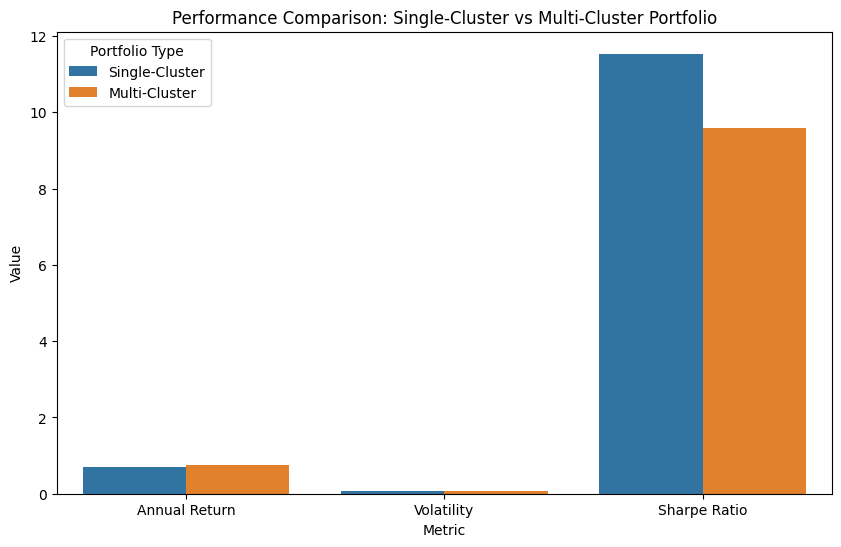

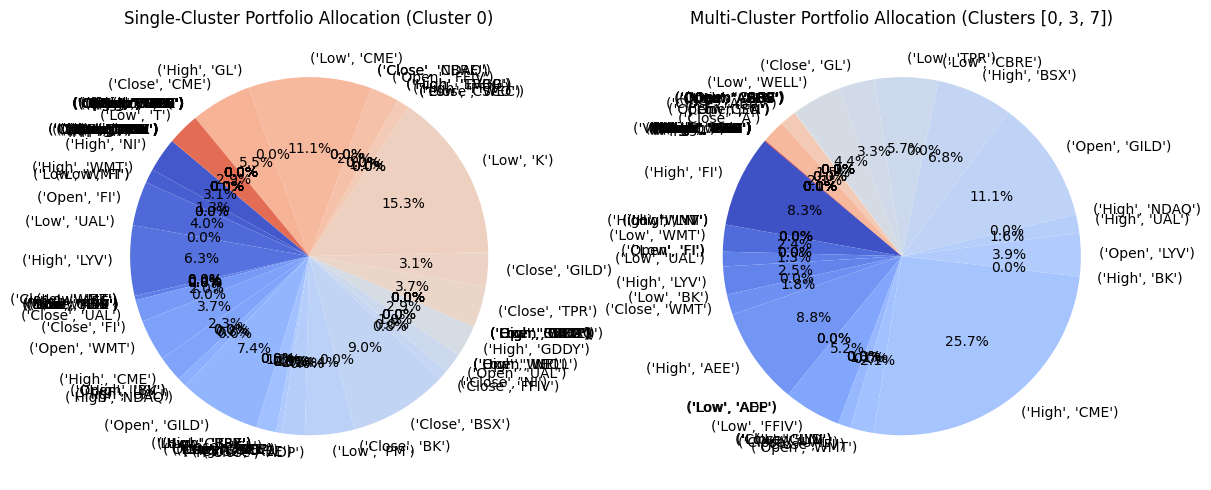

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Step 4: Visualization - Compare Portfolio Performance
# ==========================

# Create DataFrame for performance comparison
comparison_df = pd.DataFrame({
    "Metric": ["Annual Return", "Volatility", "Sharpe Ratio"],
    "Single-Cluster": [single_cluster_return, single_cluster_volatility, single_cluster_sharpe],
    "Multi-Cluster": [multi_cluster_return, multi_cluster_volatility, multi_cluster_sharpe]
})

# Bar Plot - Performance Comparison
plt.figure(figsize=(10, 6))
comparison_df_melted = comparison_df.melt(id_vars="Metric", var_name="Portfolio", value_name="Value")
sns.barplot(x="Metric", y="Value", hue="Portfolio", data=comparison_df_melted, palette=["#1f77b4", "#ff7f0e"])
plt.title("Performance Comparison: Single-Cluster vs Multi-Cluster Portfolio")
plt.ylabel("Value")
plt.xlabel("Metric")
plt.legend(title="Portfolio Type")
plt.show()


# ==========================
# Step 5: Visualization - Portfolio Allocation
# ==========================

# Pie Chart - Single-Cluster Allocation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(single_cluster_weights, labels=filtered_single_returns.columns, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("coolwarm", len(single_cluster_weights)))
plt.title(f"Single-Cluster Portfolio Allocation (Cluster {selected_cluster})")

# Pie Chart - Multi-Cluster Allocation
plt.subplot(1, 2, 2)
plt.pie(multi_cluster_weights, labels=filtered_multi_returns.columns, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("coolwarm", len(multi_cluster_weights)))
plt.title(f"Multi-Cluster Portfolio Allocation (Clusters {selected_clusters})")

plt.tight_layout()
plt.show()


✅ How to Interpret the Visuals
📊 Bar Chart Results:

If Multi-Cluster Sharpe Ratio is higher → It has better risk-adjusted returns.
If Single-Cluster Return is higher but has high volatility → It is riskier but might give better gains.
📉 Pie Chart Results:

If Single-Cluster allocation is concentrated → It lacks diversification.
If Multi-Cluster allocation is spread out → Better diversified.
